In [1]:
# libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# data
from data.data import data
from data.sys_data import sys_data 

# setup
sns.set_theme()

In [2]:
# get data
raw_dataset = data.parse_data('../report.txt')
df = pd.DataFrame(raw_dataset)

print("Peak Bandwidth: ", sys_data.peak_theoretical_bandwidth, "GB/s")
print(raw_dataset)

Peak Bandwidth:  42.94967296 GB/s
                     name          time   space
0                    loop  3.915840e-07     100
1                    loop  3.729490e-06    1000
2                    loop  3.717980e-05   10000
3                    loop  3.279940e-04  100000
4         vectorized_loop  3.170340e-07     100
5         vectorized_loop  3.137950e-06    1000
6         vectorized_loop  2.987590e-05   10000
7         vectorized_loop  2.727640e-04  100000
8          write and read  3.799430e-07     400
9          write and read  3.602280e-06    4000
10         write and read  3.540200e-05   40000
11         write and read  1.742900e-04  200000
12         write and read  3.490970e-04  400000
13           write serial  1.882410e-07     100
14           write serial  1.619440e-06    1000
15           write serial  1.589590e-05   10000
16           write serial  7.872540e-05   50000
17           write serial  1.564820e-04  100000
18           write random  2.457030e-07     100
19    

# Write and Read

In [3]:
df_bandwidth = df.loc[df.name =='write and read'].copy()
df_bandwidth['bandwidth'] = \
    df_bandwidth.apply(lambda row: \
        data.effective_bandwidth(row.space, row.time, True) / 1e9, \
    axis=1 \
    )
print(df_bandwidth)

              name          time   space  bandwidth
8   write and read  3.799430e-07     400   2.105579
9   write and read  3.602280e-06    4000   2.220816
10  write and read  3.540200e-05   40000   2.259759
11  write and read  1.742900e-04  200000   2.295026
12  write and read  3.490970e-04  400000   2.291627


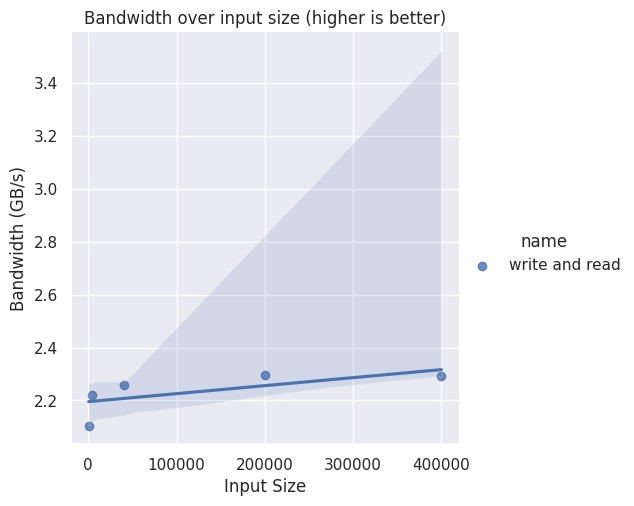

In [4]:
sns.lmplot(
    data=df_bandwidth, hue='name', 
    x="space", y="bandwidth",
)
plt.title('Bandwidth over input size (higher is better)')
plt.xlabel('Input Size')
plt.ylabel('Bandwidth (GB/s)')
plt.show()

# Float sum

In [5]:
df_flops = df.loc[df.name == 'float sum'].copy()
df_flops['bandwidth'] = \
    df_flops.apply(lambda row: \
        data.effective_bandwidth(row.space * 4, row.time, True) / 1e9, \
    axis=1 \
    )
print(df_flops)

         name          time   space  bandwidth
23  float sum  2.827340e-07     100   2.829515
24  float sum  2.664120e-06    1000   3.002868
25  float sum  2.555380e-05   10000   3.130650
26  float sum  1.231910e-04   50000   3.246990
27  float sum  2.438640e-04  100000   3.280517


In [6]:
# insert max teoretical bandwidth
df_max = pd.DataFrame({
    'name': [f'theoretical max' for space in df_flops.space.unique()],
    'space': df_flops.space.unique(),
    'bandwidth': sys_data.peak_theoretical_bandwidth # Calculate theoretical max bandwidth
})
df_final = pd.concat([df_flops, df_max])
print(df_final)

               name          time   space  bandwidth
23        float sum  2.827340e-07     100   2.829515
24        float sum  2.664120e-06    1000   3.002868
25        float sum  2.555380e-05   10000   3.130650
26        float sum  1.231910e-04   50000   3.246990
27        float sum  2.438640e-04  100000   3.280517
0   theoretical max           NaN     100  42.949673
1   theoretical max           NaN    1000  42.949673
2   theoretical max           NaN   10000  42.949673
3   theoretical max           NaN   50000  42.949673
4   theoretical max           NaN  100000  42.949673


Text(62.01787500000002, 0.5, 'Bandwidth (GB/s)')

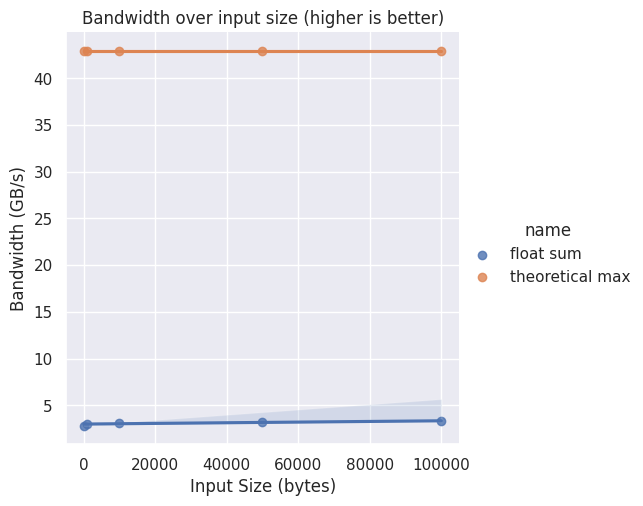

In [7]:
sns.lmplot(
    data=df_final, hue='name', 
    x="space", y="bandwidth",
)
plt.title('Bandwidth over input size (higher is better)')
plt.xlabel('Input Size (bytes)')
plt.ylabel('Bandwidth (GB/s)')

         name          time   space         flops
23  float sum  2.827340e-07     100  3.536893e+08
24  float sum  2.664120e-06    1000  3.753585e+08
25  float sum  2.555380e-05   10000  3.913312e+08
26  float sum  1.231910e-04   50000  4.058738e+08
27  float sum  2.438640e-04  100000  4.100646e+08


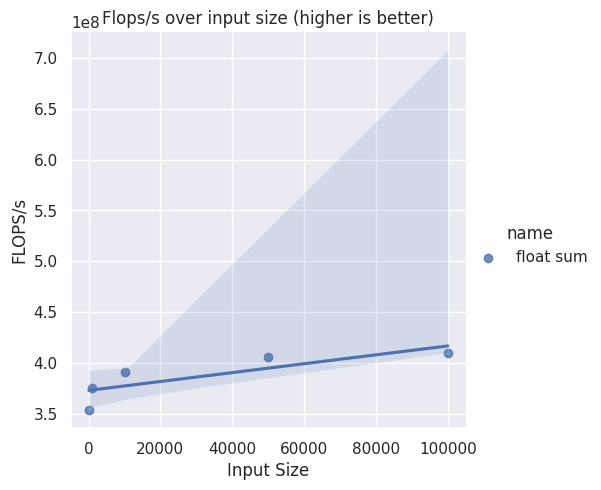

In [8]:
df_flops = df.loc[df.name == 'float sum'].copy()
df_flops['flops'] = \
    df_flops.apply(\
        lambda row: \
            data.flops(row.space, row.time), \
        axis=1 \
    )
print(df_flops)

sns.lmplot(
    data=df_flops, hue='name', 
    x="space", y="flops",
)
plt.title('Flops/s over input size (higher is better)')
plt.xlabel('Input Size')
plt.ylabel('FLOPS/s')
plt.show()

# Sequencial vs Random write

In [9]:
df_sequencial = df.loc[df.name.isin(['write serial', 'write random'])].copy()
# multiply the space by sizeof(int) and by two because we are doing reads and writes
df_sequencial['bandwidth'] = \
    df_sequencial.apply(\
        lambda row: \
            data.effective_bandwidth(row.space * 4 * 2, row.time, True) / 1e9, \
        axis=1, \
    )
print(df_sequencial)

            name          time   space  bandwidth
13  write serial  1.882410e-07     100   8.499742
14  write serial  1.619440e-06    1000   9.879959
15  write serial  1.589590e-05   10000  10.065489
16  write serial  7.872540e-05   50000  10.161905
17  write serial  1.564820e-04  100000  10.224818
18  write random  2.457030e-07     100   6.511927
19  write random  2.300190e-06    1000   6.955947
20  write random  2.216080e-05   10000   7.219956
21  write random  1.065990e-04   50000   7.504761
22  write random  2.130610e-04  100000   7.509586


In [10]:
# insert max teoretical bandwidth
df_max = pd.DataFrame({
    'name': ['theoretical max' for space in df_sequencial.space.unique()],
    'space': df_sequencial.space.unique(),
    'bandwidth': sys_data.peak_theoretical_bandwidth # Calculate theoretical max bandwidth
})
df_sequencial = pd.concat([df_sequencial, df_max])
print(df_sequencial)

               name          time   space  bandwidth
13     write serial  1.882410e-07     100   8.499742
14     write serial  1.619440e-06    1000   9.879959
15     write serial  1.589590e-05   10000  10.065489
16     write serial  7.872540e-05   50000  10.161905
17     write serial  1.564820e-04  100000  10.224818
18     write random  2.457030e-07     100   6.511927
19     write random  2.300190e-06    1000   6.955947
20     write random  2.216080e-05   10000   7.219956
21     write random  1.065990e-04   50000   7.504761
22     write random  2.130610e-04  100000   7.509586
0   theoretical max           NaN     100  42.949673
1   theoretical max           NaN    1000  42.949673
2   theoretical max           NaN   10000  42.949673
3   theoretical max           NaN   50000  42.949673
4   theoretical max           NaN  100000  42.949673


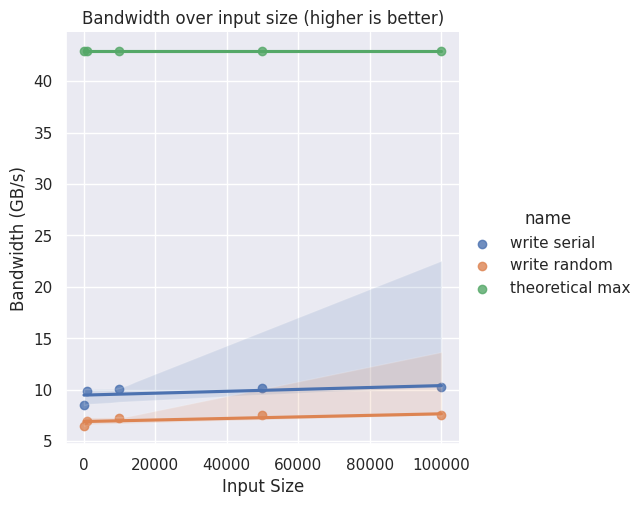

In [11]:
sns.lmplot(
    data=df_sequencial, hue='name', 
    x="space", y="bandwidth",
)
plt.title('Bandwidth over input size (higher is better)')
plt.xlabel('Input Size')
plt.ylabel('Bandwidth (GB/s)')
plt.show()

# Matrix Multiplication

In [12]:
df_mmul = df.loc[df.name == 'matrix multiplication'].copy()
df_mmul['bandwidth'] = \
    df_mmul.apply(\
        lambda row: \
            data.effective_bandwidth(row.space**2 *4, row.time, True) / 1e9, \
        axis=1, \
    )
print(df_mmul)

                     name      time  space  bandwidth
28  matrix multiplication  0.000004     10   0.210668
29  matrix multiplication  0.000052     25   0.096825
30  matrix multiplication  0.000392     50   0.051060
31  matrix multiplication  0.001297     75   0.034696
32  matrix multiplication  0.003041    100   0.026307


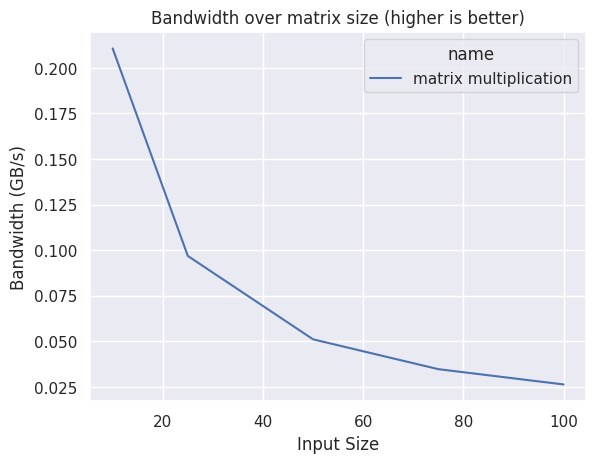

In [13]:
sns.lineplot(
    data=df_mmul, hue='name', 
    x="space", y="bandwidth",
)
plt.title('Bandwidth over matrix size (higher is better)')
plt.xlabel('Input Size')
plt.ylabel('Bandwidth (GB/s)')
plt.show()

In [14]:
df_mmul_flops = df.loc[df.name == 'matrix multiplication'].copy()
df_mmul_flops['flops'] = \
    df_mmul_flops.apply(\
        lambda row: \
            data.flops(row.space**2 * 2, row.time),
        axis=1, \
    )
print(df_mmul_flops)

                     name      time  space         flops
28  matrix multiplication  0.000004     10  5.266692e+07
29  matrix multiplication  0.000052     25  2.420614e+07
30  matrix multiplication  0.000392     50  1.276497e+07
31  matrix multiplication  0.001297     75  8.673930e+06
32  matrix multiplication  0.003041    100  6.576719e+06


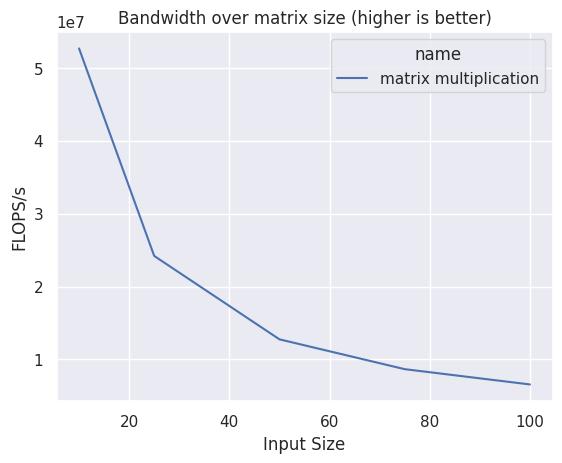

In [15]:
sns.lineplot(
    data=df_mmul_flops, hue='name', 
    x="space", y="flops",
)
plt.title('Bandwidth over matrix size (higher is better)')
plt.xlabel('Input Size')
plt.ylabel('FLOPS/s')
plt.show()